# Understanding Magazine Subscription Behavior

### Introduction
A magazine company is trying to understand last year’s decline in subscriptions. With more people spending time at home, the company expected that people would be spending more time reading. Using the provided dataset, this project aims to analyze subscription behavior and predict potential subscribers. We will build and fine-tune logistic regression and SVM models to better understand the key factors influencing subscription behavior.

## Part 1: Data Cleansing and Feature Engineering

In [ ]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = 'marketing_campaign.xlsx'
df = pd.read_excel(file_path)

# Handle missing values and outliers in 'Income'
df['Income'].fillna(df['Income'].median(), inplace=True)
income_99th_percentile = df['Income'].quantile(0.99)
df['Income'] = df['Income'].clip(upper=income_99th_percentile)

# Feature Engineering: Create 'Customer_Tenure'
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Customer_Tenure'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days

# Encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)

# Display the updated dataset
df_encoded.head()

<ipython-input-1-807676ed6f0b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,...,True,False,False,False,False,False,True,False,False,False
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,...,True,False,False,False,False,False,True,False,False,False
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,True,False,False,False,False,False,False,True,False,False
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,...,True,False,False,False,False,False,False,True,False,False
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,False,False,True,False,False,True,False,False,False,False


## Part 2: Handling Multicollinearity

In [ ]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Drop features with high multicollinearity
X = df_encoded.drop(columns=['ID', 'Response', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue',
                             'Marital_Status_Married', 'Marital_Status_Single',
                             'Marital_Status_Together', 'Marital_Status_Divorced',
                             'Year_Birth', 'NumWebVisitsMonth', 'Income']).copy()

# Convert boolean columns to integers if needed
X = X.astype({col: 'int64' for col in X.select_dtypes(include=['bool']).columns})

# Ensure all columns are numeric and replace any infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaN values
X.dropna(inplace=True)

# Recalculate VIF after removing highly collinear features
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
vif_data


,feature,VIF
0,Kidhome,3.060315
1,Teenhome,2.640426
2,Recency,3.909735
3,MntWines,6.052780
4,MntFruits,2.802433
5,MntMeatProducts,4.320837
6,MntFishProducts,3.136779
7,MntSweetProducts,2.747877
8,MntGoldProds,2.662535
9,NumDealsPurchases,3.712793


## Part 3: Logistic Regression Model

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       379
           1       0.71      0.36      0.48        69

    accuracy                           0.88       448
   macro avg       0.80      0.67      0.71       448
weighted avg       0.87      0.88      0.86       448



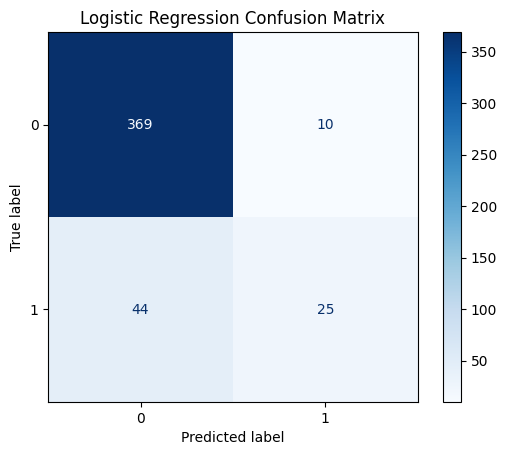

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define features and target
y = df_encoded['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Make predictions on test data
y_pred_log = log_model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred_log))

# Display confusion matrix
log_conf_matrix = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=log_conf_matrix, display_labels=log_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

## Part 4: Support Vector Machine (SVM) Model

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       379
           1       0.73      0.28      0.40        69

    accuracy                           0.87       448
   macro avg       0.81      0.63      0.66       448
weighted avg       0.86      0.87      0.85       448



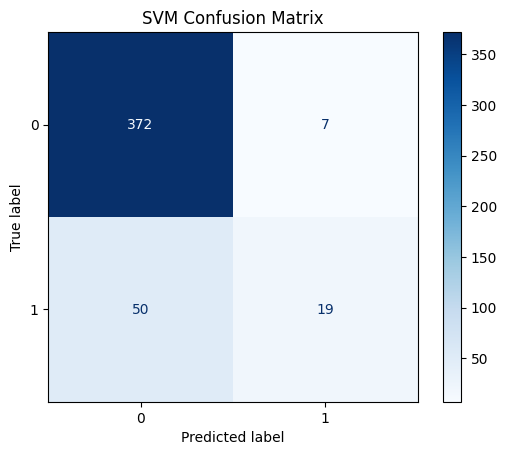

In [ ]:
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)

# Make predictions on test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred_svm))

# Display confusion matrix
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=svm_conf_matrix, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show()

## Part 5: Fine-Tuning Logistic Regression and SVM

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       379
           1       0.71      0.36      0.48        69

    accuracy                           0.88       448
   macro avg       0.80      0.67      0.71       448
weighted avg       0.87      0.88      0.86       448



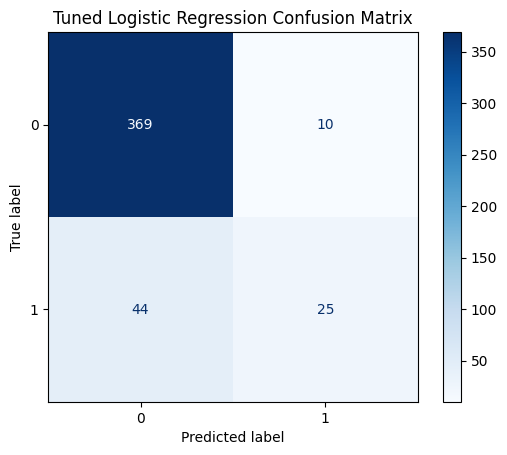

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Logistic Regression
param_grid_log = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_log = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log, cv=5, scoring='f1')
grid_log.fit(X_train_scaled, y_train)

# Best parameters for Logistic Regression
print(f"Best parameters for Logistic Regression: {grid_log.best_params_}")

# Evaluate tuned Logistic Regression
y_pred_log_tuned = grid_log.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred_log_tuned))

# Confusion matrix for tuned logistic regression
log_conf_matrix_tuned = confusion_matrix(y_test, y_pred_log_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=log_conf_matrix_tuned, display_labels=grid_log.best_estimator_.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Tuned Logistic Regression Confusion Matrix')
plt.show()

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       379
           1       0.76      0.28      0.40        69

    accuracy                           0.88       448
   macro avg       0.82      0.63      0.67       448
weighted avg       0.86      0.88      0.85       448



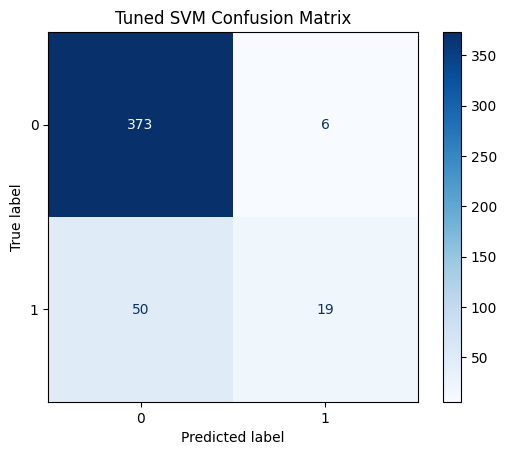

In [ ]:
# Hyperparameter tuning for SVM
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='f1')
grid_svm.fit(X_train_scaled, y_train)

# Best parameters for SVM
print(f"Best parameters for SVM: {grid_svm.best_params_}")

# Evaluate tuned SVM
y_pred_svm_tuned = grid_svm.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred_svm_tuned))

# Confusion matrix for tuned SVM
svm_conf_matrix_tuned = confusion_matrix(y_test, y_pred_svm_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=svm_conf_matrix_tuned, display_labels=grid_svm.best_estimator_.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Tuned SVM Confusion Matrix')
plt.show()

## Part 6: Model Comparison and Final Recommendation

In [ ]:
from sklearn.metrics import accuracy_score

# Compare the accuracy of logistic regression and SVM
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f'Logistic Regression Accuracy: {accuracy_log}')
print(f'SVM Accuracy: {accuracy_svm}')

# Final recommendation
if accuracy_log > accuracy_svm:
    print("Logistic Regression is the recommended model based on higher accuracy.")
else:
    print("SVM is the recommended model based on higher accuracy.")

Logistic Regression Accuracy: 0.8794642857142857
SVM Accuracy: 0.8727678571428571
Logistic Regression is the recommended model based on higher accuracy.
